In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import gc

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from PIL import Image
from sklearn.model_selection import train_test_split

import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers

import wandb



wandb.login()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

1. Explore the dataset through code

1.a How many images does the dataset contain?

What the following code does, is open the path where the hole dataset is stored, and run through all the different files using a for loop. At each loop iteration, a variable is incremented. When the code has finished running through every image, it will display the variable which will correspond to the number of images.

In [2]:
ii = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        ii +=1
print(ii)


56092


1.b How many classes? How many images per class? Show a histogram of the number of instances per class

The number of classes is 6. There are three different structures, and each one of them can be cracked or non-cracked, meaning that there are 6 possible classifications.

The number of images per class is calculated in the following code, where the number of images for each class is stored in imgcount. This code goes specifically through each folder where images are stored (6 folders) and for each folders. Once it is inside the folder, it will increase a variable for each image that has found and saveing it at the imgcount list.

In [3]:
classcount = 0
labelname = []
classname = []
imgcount = []
paths = []
for dirname in os.listdir('/kaggle/input'):
    for folder in os.listdir('/kaggle/input/' + dirname):
        classname.append(folder)
        classcount +=1
        for label in os.listdir('/kaggle/input/' + dirname + '/' + folder):
            labelname.append(label)
            paths.append('/kaggle/input/' + dirname + '/' + folder + '/' + label)
            imgcount.append(0)
            for img in os.listdir('/kaggle/input/' + dirname + '/' + folder + '/' + label):
                imgcount[-1] += 1

print("Number of classes :", classcount)
for ii in range(len(labelname)):
    print(classname[ii//2], labelname[ii], ":", imgcount[ii])
print(paths)



Number of classes : 3
Pavements Non-cracked : 21726
Pavements Cracked : 2608
Decks Non-cracked : 11595
Decks Cracked : 2025
Walls Non-cracked : 14287
Walls Cracked : 3851
['/kaggle/input/structural-defects-network-concrete-crack-images/Pavements/Non-cracked', '/kaggle/input/structural-defects-network-concrete-crack-images/Pavements/Cracked', '/kaggle/input/structural-defects-network-concrete-crack-images/Decks/Non-cracked', '/kaggle/input/structural-defects-network-concrete-crack-images/Decks/Cracked', '/kaggle/input/structural-defects-network-concrete-crack-images/Walls/Non-cracked', '/kaggle/input/structural-defects-network-concrete-crack-images/Walls/Cracked']


The following code is in charge of ploting the histogram. Firstly, the labels are defined (Decks Cracked | Decks Non-Cracked | Pavements Cracked | Pavements Non-Cracked | Walls Cracked | Walls Non-Cracked) and link each label to the position on the imgcount.

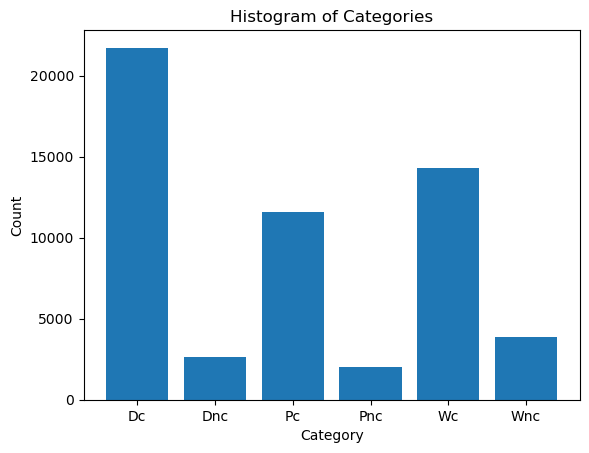

In [4]:
labels = ['Dc', 'Dnc', 'Pc', 'Pnc', 'Wc', 'Wnc']

# Create the histogram
plt.bar(labels, imgcount)

# Set the axis labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Histogram of Categories')

# Show the plot
plt.show()

1.c Show 4 random images from each class

In order to plot 4 images, the list paths has been used, which is where all the paths to the different images are saved. For each path, 4 images are appended in imgs list, for later plot the using a subplot, meaning that each plot will contain 4 images.

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


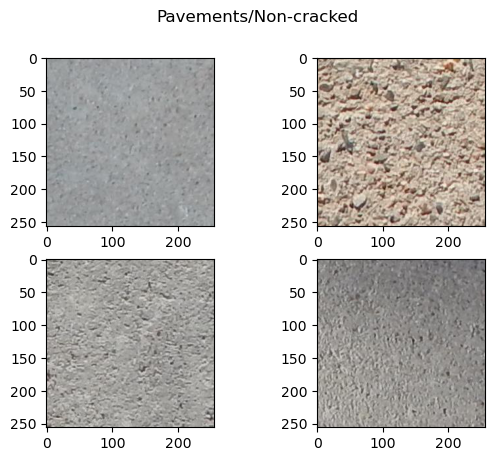

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


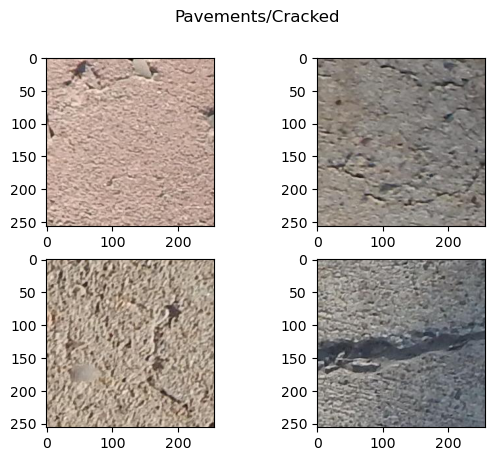

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


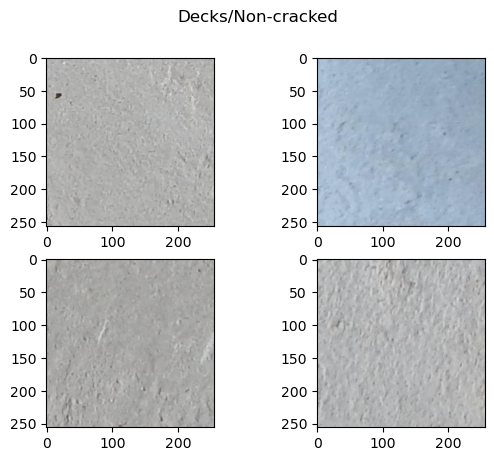

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


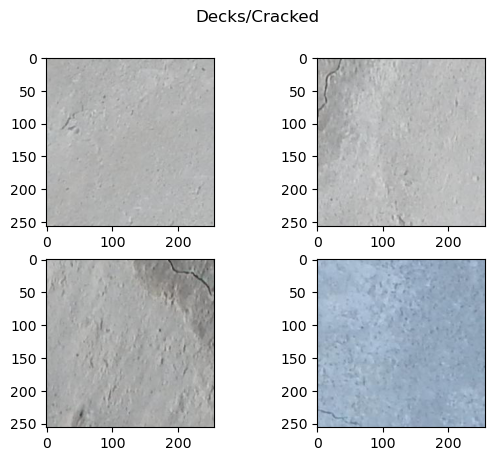

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


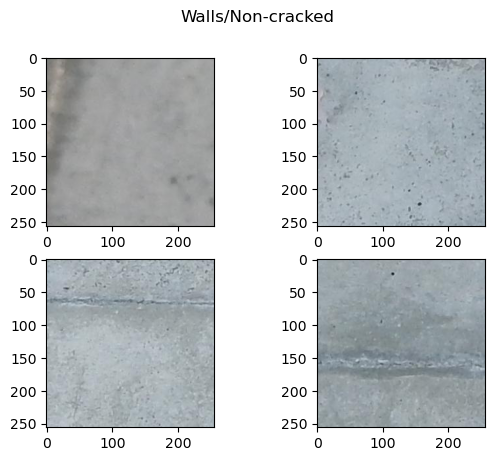

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


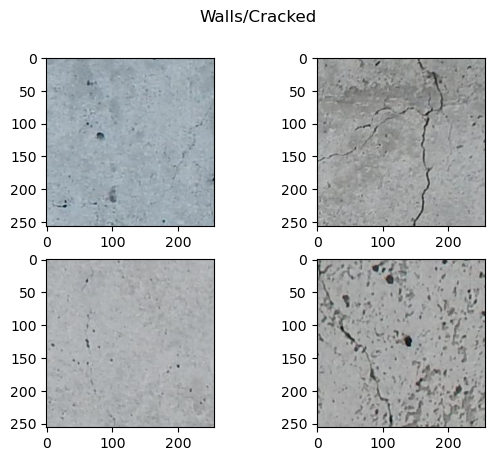

In [5]:
for path in paths:
    imgs = []
    for img in os.listdir(path)[:4]:
        # print(path + '/'+ img)
        imgs.append(mpimg.imread(path + '/'+ img))
        print(imgs[-1].shape)
        
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(nrows=2, ncols=2)

    # Plot the images in the subplots
    axs[0, 0].imshow(imgs[0])
    # axs[0, 0].set_title('Image 1')
    axs[0, 1].imshow(imgs[1])
    # axs[0, 1].set_title('Image 2')
    axs[1, 0].imshow(imgs[2])
    # axs[1, 0].set_title('Image 3')
    axs[1, 1].imshow(imgs[3])
    # axs[1, 1].set_title('Image 4')

    # Add a main title to the plot
    fig.suptitle(path.replace("/kaggle/input/structural-defects-network-concrete-crack-images/", ""))

    # Display the plot
    plt.show()

del imgs

1.d Describe if/how you think the data distribution will affect training of a classifier.


A problem that could appear and affect the accuracy could be because the accuracy of the model depends on the distribution of data in the training set. If the data is unbalanced, i.e., there are more samples of one class than the other, the model may become biased towards the dominant class and perform poorly on the minority class. That is why after loading the data and, the same amount of data has been used for each class, so in total, each class has around 2000 images. However, data augmanetation after that has been used, having 6000 images in total for each class.

1.e Decide what part of the dataset to use; all, some classes, some samples. Motivate your choice.

The created model, is able to classify among all the different structures, either cracked or non-cracked. As mentioned, for the classes with more available data, some of it has not been used to match the number of images other classes have. 



In [6]:
# The actual size of the resulting dataset is triple of the variable sizes below say, as the data is augmented
train_size = 800 # 80% 
test_size = 200   # 20%
train_data = []
train_labels = []
test_data = []
test_labels = []

random.seed(844)

data_augment_flip = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical")
])


class_id = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    if len(filenames) == 0:
        continue
        
    print(dirname)
    files_raw = random.choices(filenames[:train_size + test_size], k=train_size + test_size)
    files_train = files_raw[:train_size]
    files_test = files_raw[train_size:train_size + test_size]
    for file in files_train:
        
        img = Image.open(os.path.join(dirname, file)).convert('RGB')
        img = img.resize((64, 64),mpimg.NEAREST)
        img = np.array(img)
        img = img / 255.0
        train_data.append(img)
        train_data.append(data_augment_flip(img)) # augment flip
        train_data.append(tf.image.rot90(img)) # augment rotate 90 degrees 
        for _ in range(3): train_labels.append(class_id)
        
    
    for file in files_test:
        img = Image.open(os.path.join(dirname, file)).convert('RGB') # Open and convert image to RBG format
        img = img.resize((64, 64),mpimg.NEAREST) # Downscale image
        img = np.array(img)
        img = img / 255.0 # Normalize data
        test_data.append(img)
        test_data.append(data_augment_flip(img)) # augment flip
        test_data.append(tf.image.rot90(img)) # augment rotate 90 degrees 
        for _ in range(3): test_labels.append(class_id)
    
    class_id += 1


/kaggle/input/structural-defects-network-concrete-crack-images/Pavements/Non-cracked
/kaggle/input/structural-defects-network-concrete-crack-images/Pavements/Cracked
/kaggle/input/structural-defects-network-concrete-crack-images/Decks/Non-cracked
/kaggle/input/structural-defects-network-concrete-crack-images/Decks/Cracked
/kaggle/input/structural-defects-network-concrete-crack-images/Walls/Non-cracked
/kaggle/input/structural-defects-network-concrete-crack-images/Walls/Cracked


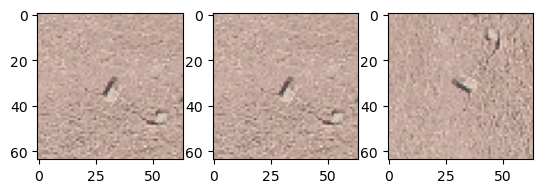

In [7]:
fig, axs = plt.subplots(ncols=3)

axs[0].imshow(train_data[train_size*3])
axs[1].imshow(train_data[train_size*3 + 1])
axs[2].imshow(train_data[train_size*3 + 2])


Model layer creation

In [8]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="DL_Mini_Project",
    config = {
        "learning_rate": "[0.002, 0.001, 0.0005]",
        "batch sizes": "[32, 64, 128]",
        "network layers": "[4/2, 3/2, 2/2]",
        "architecture": "CNN",
        "dataset": "SDNET",
        "epochs": 50,
        "User ID": "Bernat",
    }
)




wandb: Currently logged in as: boller22 (japanesegoblin). Use `wandb login --relogin` to force relogin


In [9]:
def generate_model(l):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    if l == 4:
        model.add(layers.MaxPooling2D((4, 4)))
    elif l == 5:
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    else:
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(6, activation="softmax"))
    return model


In [10]:
batch_sizes = [32, 64, 128]
learning_rates = [0.002, 0.001, 0.0005]
epochs = 50

best_model_acc = 0
best_model_id = "None"
best_model_hist = None
for model_id in [6,5,4]:
    
    for batch_size in batch_sizes:
        
        for learning_rate in learning_rates:
            
            tf.keras.backend.clear_session()
            gc.collect()
            model = generate_model(model_id)

            model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
            
            print(f"Train model layers {model_id}, batch size: {batch_size}, learning rate: {learning_rate}")
            history = model.fit(np.array(train_data), np.array(train_labels), batch_size=batch_size, verbose=0, epochs=epochs, validation_data=(np.array(test_data), np.array(test_labels)))
            
            print("Accuracy:", history.history['accuracy'][-1], "\nVal accuracy:", history.history['val_accuracy'][-1], "\n")
            
            if best_model_acc < history.history['val_accuracy'][-1]:
                best_model_acc = history.history['val_accuracy'][-1]
                model.save('best_model')
                best_model_id = f"model_id:{model_id}, batch_size:{batch_size}, learning_rate:{learning_rate}"
                best_model_hist = history
                
            for epoch in range(epochs):
                wandb.log({"model": model_id, 
                           "batch size": batch_size, 
                           "learning rate" : learning_rate, 
                           "epoch" : epoch, 
                           "train loss" : history.history['loss'][epoch], 
                           "train accuracy" : history.history['accuracy'][epoch], 
                           "val loss" : history.history['val_loss'][epoch], 
                           "val accuracy" : history.history['val_accuracy'][epoch]})
            

print(best_model_id)

Train model layers 6, batch size: 32, learning rate: 0.002
Accuracy: 0.8816666603088379 
Val accuracy: 0.6913889050483704 

Train model layers 6, batch size: 32, learning rate: 0.001
Accuracy: 0.9360416531562805 
Val accuracy: 0.73416668176651 

Train model layers 6, batch size: 32, learning rate: 0.0005
Accuracy: 0.9414583444595337 
Val accuracy: 0.7394444346427917 

Train model layers 6, batch size: 64, learning rate: 0.002
Accuracy: 0.901805579662323 
Val accuracy: 0.7072222232818604 

Train model layers 6, batch size: 64, learning rate: 0.001
Accuracy: 0.9242361187934875 
Val accuracy: 0.7233333587646484 

Train model layers 6, batch size: 64, learning rate: 0.0005
Accuracy: 0.8981249928474426 
Val accuracy: 0.7002778053283691 

Train model layers 6, batch size: 128, learning rate: 0.002
Accuracy: 0.8385416865348816 
Val accuracy: 0.6819444298744202 

Train model layers 6, batch size: 128, learning rate: 0.001
Accuracy: 0.855555534362793 
Val accuracy: 0.6855555772781372 

Train mo

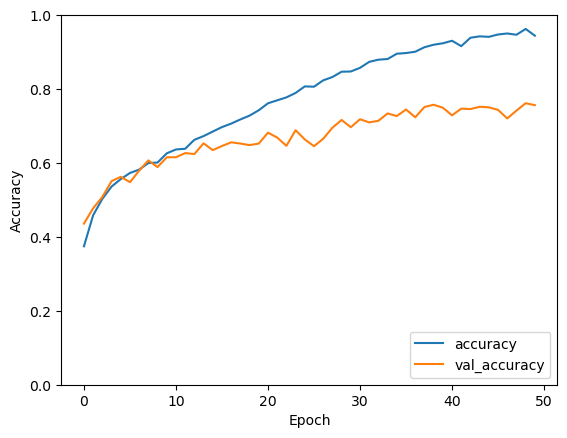

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [11]:
model = models.load_model('best_model') 

plt.plot(best_model_hist.history['accuracy'], label='accuracy')
plt.plot(best_model_hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
model.summary()

In [12]:
# Accuracy per class
for ii, class_type in enumerate(classname):
    for jj, label in enumerate(labelname[:2]):
        test_loss, test_acc = model.evaluate(np.array(  test_data[(ii*2 + jj) * test_size*3 : (ii*2 + jj + 1) * test_size*3]),  
                                             np.array(test_labels[(ii*2 + jj) * test_size*3 : (ii*2 + jj + 1) * test_size*3]),
                                             verbose=0)
        print(f"{class_type} {label} accuracy: {test_acc * 100}%")


Pavements Non-cracked accuracy: 83.33333134651184%
Pavements Cracked accuracy: 73.00000190734863%
Decks Non-cracked accuracy: 71.83333039283752%
Decks Cracked accuracy: 81.99999928474426%
Walls Non-cracked accuracy: 79.16666865348816%
Walls Cracked accuracy: 64.49999809265137%


Correct:


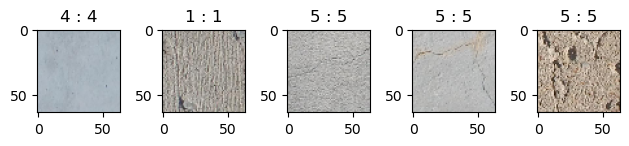

Incorrect:


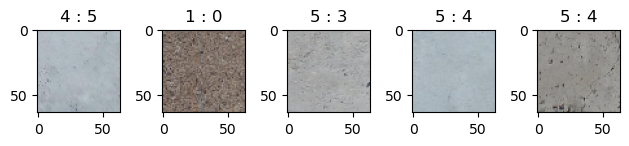

In [13]:
# Find 5 classified correctly and 5 classified incorrectly
correct = []
incorrect = []
while(len(correct) < 5 or len(incorrect) < 5):
    index = random.randint(0, len(test_data))
    
    y_hat = np.argmax(model.predict(np.array([test_data[index]]), verbose=0))
    
    if test_labels[index] == y_hat and len(correct) < 5:
        correct.append([test_data[index],y_hat])
    elif test_labels[index] != y_hat and len(incorrect) < 5:
        incorrect.append([test_data[index],test_labels[index],y_hat])


fig, axs = plt.subplots(ncols=5)

for ii in range(len(correct)):
    axs[ii].imshow(correct[ii][0])
    axs[ii].title.set_text(f"{incorrect[ii][1]} : {incorrect[ii][1]}")
print("Correct:")
plt.tight_layout()

plt.show()
    
    
fig, axs = plt.subplots(ncols=5)

for ii in range(len(incorrect)):
    axs[ii].imshow(incorrect[ii][0])
    axs[ii].title.set_text(f"{incorrect[ii][1]} : {incorrect[ii][2]}")
print("Incorrect:")
plt.tight_layout()
plt.show()


MARKDOWN
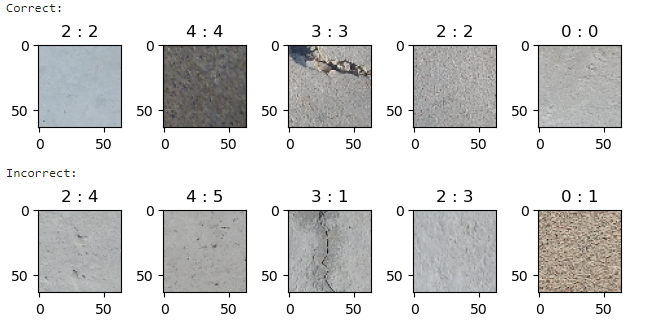
END OF MART

In [14]:
wandb.finish()

batch size,▁▁▁▁▁▃▃▃▃█████▁▁▁▁▃▃▃▃█████▁▁▁▁▃▃▃▃▃████
epoch,▃█▅▂▇▅▂▇▆▄▁▆▃█▅▂▂▇▄▂▆▄▁▆▅▃▇▅▂▇▄▂▁▆▃█▅▃▇▇
learning rate,██▃▁▁█▃▃▁█▃▃▁▁█▃▁▁█▃▃▁██▃▁▁█▃▃▁█▃▃▁▁█▃▃▁
model,██████████████▅▅▅▅▅▅▅▅▅▅▅▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁
train accuracy,▄▇▇▅█▆▄▇▇▅▁▆▄▇▆▅▄█▅▃█▅▁▆▆▄▇▆▄▇▅▃▃▆▄▅▆▄▆▅
train loss,▅▂▂▅▁▃▆▂▂▅█▃▅▂▃▅▅▁▄▆▁▄█▃▃▅▂▃▅▂▄▆▆▃▅▄▄▅▃▄
val accuracy,▅▆▆▅▇▆▅▇▇▅▂▆▅▆▆▅▅█▆▄▆▆▁▆▆▅▇▆▅▇▆▄▄▆▄▆▆▄▆▆
val loss,▂█▄▂▅▂▂▄▂▂▄▂▂▂▃▂▂▄▁▃▅▁▅▂▂▂▂▂▂▃▁▂▃▂▃▁▂▃▁▁
batch size,128
epoch,49
learning rate,0.0005
